# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Đinh Nguyễn Gia Bảo
- MSSV: 22127027
- Lớp: 22CLC03

# Import

In [97]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
import seaborn as sns # Thư viện vẽ đồ thị 
import matplotlib.pyplot as plt # Thư viện vẽ đồ thị

from sklearn.linear_model import LinearRegression # Hồi quy tuyến tính
from sklearn.metrics import mean_absolute_error # Các hàm đánh giá mô hình
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict # Tái chọn mô hình
from sklearn.preprocessing import StandardScaler # Chuẩn hóa dữ liệu cho mô hình hồi quy

# Đọc dữ liệu

In [98]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần
features = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
target = 'Performance Index'

# Cài đặt hàm

In [99]:
# Cài đặt các hàm cần thiết ở đây

def plot_true_vs_predictions(y_true, y_pred): # Hàm vẽ biểu đồ phân tán giữa giá trị thực tế và giá trị dự đoán
    """
    Vẽ biểu đồ phân tán của giá trị thực tế và giá trị dự đoán.
    
    Parameters:
    y_true (array-like): Giá trị thực tế.
    y_pred (array-like): Giá trị dự đoán.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True Values vs Predictions')
    plt.show()

def plot_regression_line(y_true, y_pred): # Hàm vẽ đường hồi quy giữa giá trị thực tế và giá trị dự đoán
    """
    Vẽ đường hồi quy giữa giá trị thực tế và giá trị dự đoán.
    
    Parameters:
    y_true (array-like): Giá trị thực tế.
    y_pred (array-like): Giá trị dự đoán.
    """
    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_true, y=y_pred, scatter_kws={'s':30}, line_kws={'color':'red'})
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Line for True Values vs Predictions')
    plt.show()

def printMAE(y_true, y_pred): # Hàm in ra giá trị Mean Absolute Error
    """
    Đánh giá mô hình bằng cách tính toán Mean Absolute Error (MAE).

    Parameters:
    y_true (array-like): Giá trị thực tế.
    y_pred (array-like): Giá trị dự đoán.

    Returns:
    None
    """
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Mean Absolute Error: {mae:.3f}")

def create_regression_formula(intercept, coefficients, features): # Hàm tạo công thức hồi quy từ hệ số chệch, các hệ số hồi quy và các đặc trưng
    """
    Tạo công thức hồi quy từ hệ số chệch, các hệ số hồi quy và các đặc trưng.

    Parameters:
    intercept (float): Hệ số chệch của mô hình hồi quy.
    coefficients (array-like): Các hệ số hồi quy của các đặc trưng.
    features (list of str): Danh sách các đặc trưng.

    Returns:
    str: Công thức hồi quy.
    """
    intercept = round(intercept, 3)
    coefficients = np.round(coefficients, 3)
    
    formula = f"Student Performance = {intercept} "
    formula += " ".join([f"+ {coeff} * {feature}" for coeff, feature in zip(coefficients, features) if coeff != 0])
    
    return formula

def plot_mean_r2_scores(results): # Hàm vẽ biểu đồ trực quan hóa Mean R^2 Scores cho từng đặc trưng
    """
    Trực quan hóa Mean R^2 Scores cho từng đặc trưng.

    Parameters:
    results (dict): Từ điển với tên đặc trưng là key và Mean R^2 Score là giá trị.

    Returns:
    None
    """
    # Tạo một DataFrame để lưu trữ kết quả
    results_df = pd.DataFrame({
        'Feature': list(results.keys()),
        'Mean R^2 Score': list(results.values())
    })

    # Sắp xếp theo Mean R^2 Score
    results_df = results_df.sort_values(by='Mean R^2 Score', ascending=False)

    # Vẽ biểu đồ cột
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Mean R^2 Score', y='Feature', data=results_df, palette='viridis')

    # Thêm giá trị vào từng cột
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.6f}', (p.get_width() + 0.01, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

    plt.xlabel('Mean R^2 Score')
    plt.ylabel('Feature')
    plt.title('Mean R^2 Scores for Each Feature')
    plt.show()

*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu (1 điểm)

   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0              7               77                           0            5   
1              8               90                           1            4   
2              9               83                           1            6   
3              4               52                           0            9   
4              4               82                           1            8   

   Sample Question Papers Practiced  Performance Index  
0                                 2               69.0  
1                                 1               84.0  
2                                 3               82.0  
3                                 5               38.0  
4                                 6               68.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------         

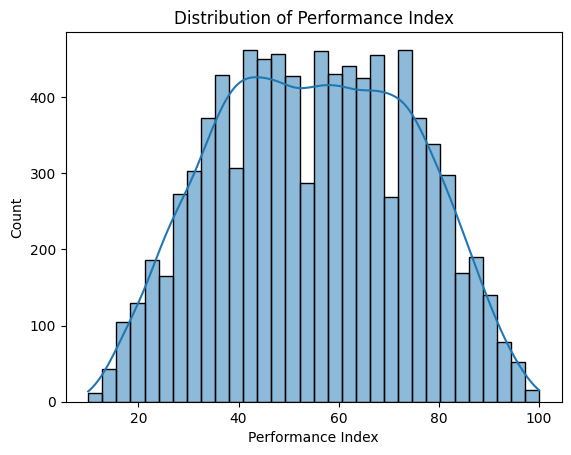

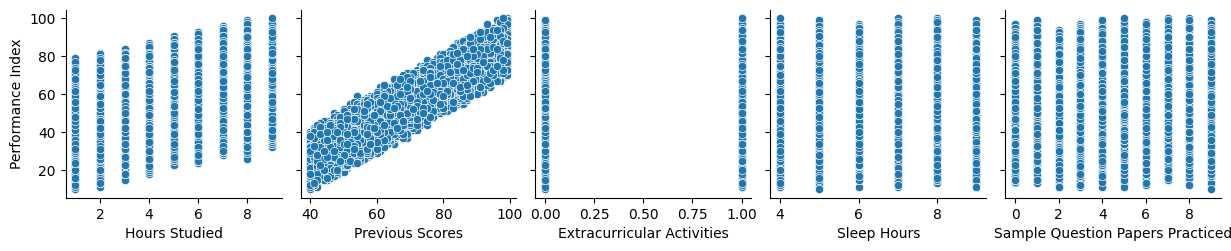

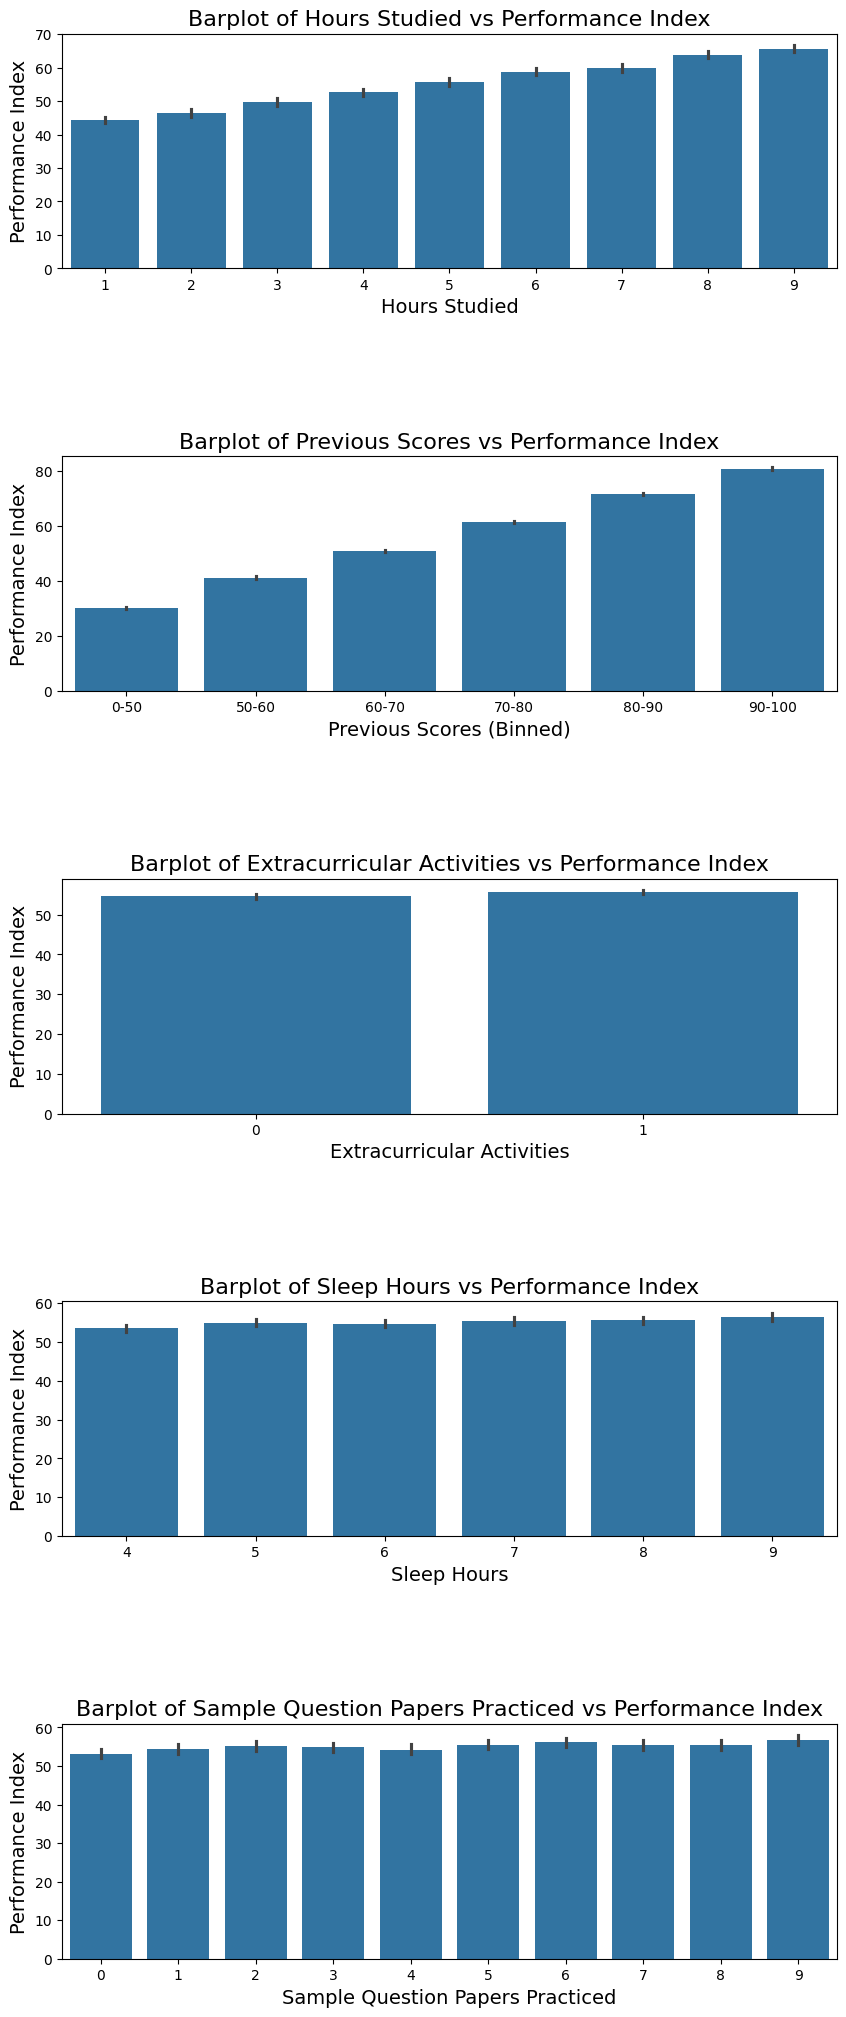

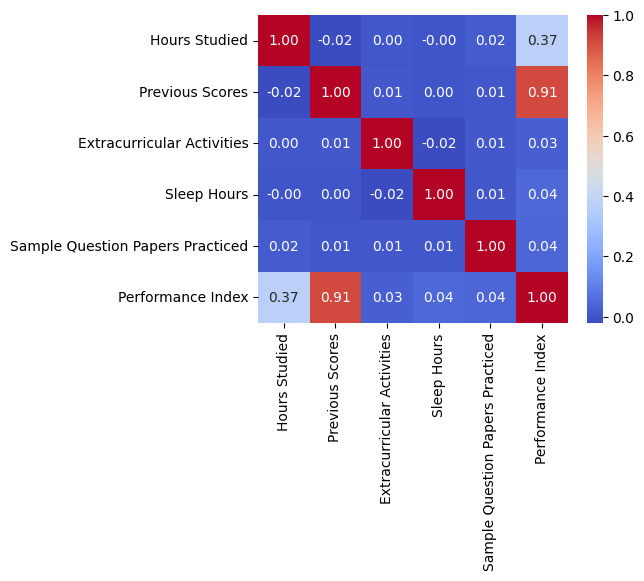

In [100]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện

# Đọc dữ liệu từ file CSV
train = pd.read_csv('train.csv')
# 1. Kiểm tra dữ liệu
print(train.head())        # Hiển thị những dòng đầu tiên của dữ liệu
print(train.info())        # Kiểm tra thông tin tổng quan về dữ liệu
print(train.describe())    # Thống kê mô tả

# 2. Kiểm tra giá trị thiếu
print(train.isnull().sum())  # Đếm số lượng giá trị thiếu trong mỗi cột

# 3. Phân tích mối quan hệ giữa các biến
# Ma trận tương quan
corr_matrix = train.corr()
print(corr_matrix)

# 4. Trực quan hóa dữ liệu

# Biểu đồ phân phối của Performance Index
sns.histplot(train['Performance Index'], kde=True)
plt.title('Distribution of Performance Index')
plt.show()

# Biểu đồ phân tán giữa các yếu tố và Performance Index
sns.pairplot(train, y_vars='Performance Index', 
             x_vars=['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced'], 
             kind='scatter')

plt.show()

# Biểu đồ cột
# Phân loại Previous Scores thành các nhóm (bins)
bins = [0, 50, 60, 70, 80, 90, 100]
labels = ['0-50', '50-60', '60-70', '70-80', '80-90', '90-100']
train['Previous Scores Binned'] = pd.cut(train['Previous Scores'], bins=bins, labels=labels)

# Tăng kích thước của figure để chứa các biểu đồ
plt.figure(figsize=(10, 25))

# Lặp qua từng feature và tạo biểu đồ cột
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i + 1)  # Chia subplot, mỗi hàng là một biểu đồ
    if feature == 'Previous Scores':  # Nếu feature là Previous Scores thì sử dụng phiên bản binned
        sns.barplot(x='Previous Scores Binned', y='Performance Index', data=train)
        plt.xlabel('Previous Scores (Binned)', fontsize=14)
    else:  # Các feature khác được vẽ bình thường
        sns.barplot(x=feature, y='Performance Index', data=train)
        plt.xlabel(feature, fontsize=14)
    
    plt.title(f'Barplot of {feature} vs Performance Index', fontsize=16)  # Tăng kích thước chữ tiêu đề
    plt.ylabel('Performance Index', fontsize=14)  # Tăng kích thước chữ trục y

# Điều chỉnh khoảng cách giữa các subplots để tăng không gian giữa các biểu đồ
plt.subplots_adjust(hspace=0.8)  # Tăng hspace để tạo thêm khoảng cách giữa các biểu đồ

plt.show()

# Vẽ heatmap để trực quan hóa ma trận tương quan
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp (2 điểm) 

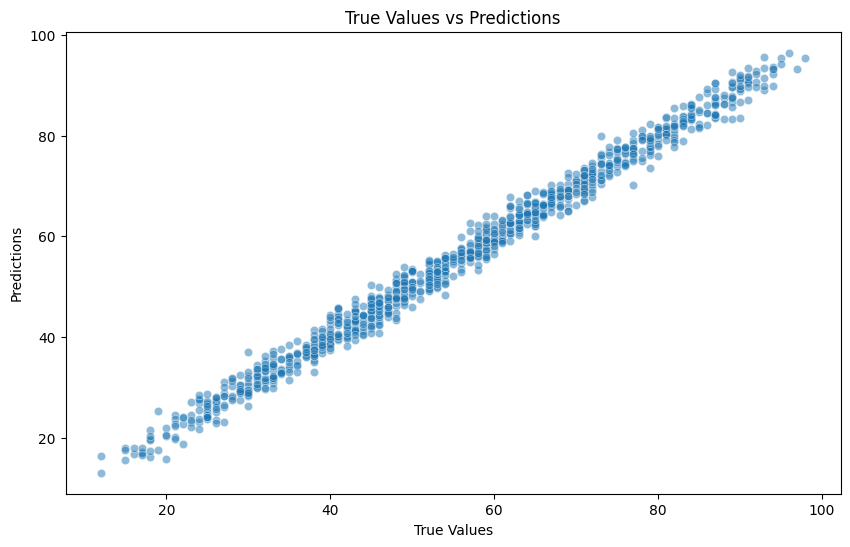

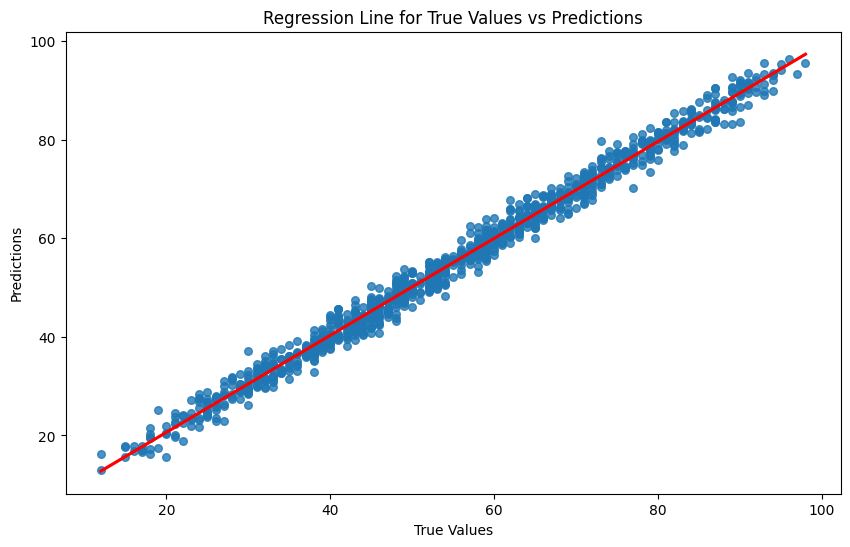

In [101]:
# Phần code cho yêu cầu 2a

# Tạo mô hình hồi quy tuyến tính
model = LinearRegression()

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Vẽ biểu đồ phân tán của giá trị thực tế và giá trị dự đoán
plot_true_vs_predictions(y_test, y_pred)

# Vẽ đường hồi quy
plot_regression_line(y_test, y_pred)

In [102]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
# Đánh giá mô hình
printMAE(y_test, y_pred)

# In ra công thức hồi quy
formula = create_regression_formula(model.intercept_, model.coef_, features)
print(formula)

Mean Absolute Error: 1.596
Student Performance = -33.969 + 2.852 * Hours Studied + 1.018 * Previous Scores + 0.604 * Extracurricular Activities + 0.474 * Sleep Hours + 0.192 * Sample Question Papers Practiced


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = ...$$

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất (2 điểm)

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng


The best feature is: Previous Scores with a mean R^2 score of: 0.8365819535716327

R^2 scores for each feature:
- Hours Studied, Fold R^2 Scores: [0.11986998 0.15947627 0.12373949 0.13091999 0.14056384], Mean R^2 Score: 0.13491391477220951
- Previous Scores, Fold R^2 Scores: [0.83608216 0.8352534  0.83671487 0.83534227 0.83951707], Mean R^2 Score: 0.8365819535716327
- Extracurricular Activities, Fold R^2 Scores: [-0.00456081  0.00149733  0.00066903  0.00091722 -0.00274613], Mean R^2 Score: -0.0008446721254732114
- Sleep Hours, Fold R^2 Scores: [-0.00291756 -0.00398398  0.00299927  0.00195723  0.00306268], Mean R^2 Score: 0.00022352944552286313
- Sample Question Papers Practiced, Fold R^2 Scores: [-0.00636833  0.00092356  0.00202353  0.00030237  0.00300803], Mean R^2 Score: -2.217020897627986e-05


C:\Users\Admin\AppData\Local\Temp\ipykernel_14528\2874121427.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Mean R^2 Score', y='Feature', data=results_df, palette='viridis')


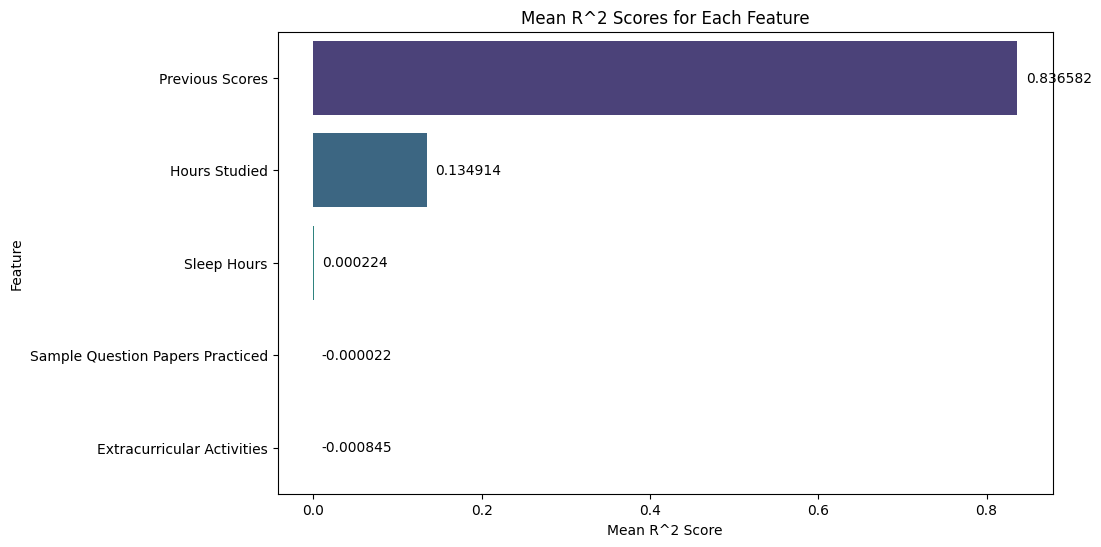

In [103]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu

# Tạo đối tượng k-fold cross validation với k = 5
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Khởi tạo mô hình hồi quy tuyến tính
model = LinearRegression()

# Lưu kết quả R^2 score của từng đặc trưng
results = {}

for feature in features:
    X = train[[feature]]  # Chọn một đặc trưng duy nhất
    y = train[target]     # Biến mục tiêu

    # Tính R^2 score sử dụng cross_val_score
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    # Lưu lại kết quả trung bình
    results[feature] = np.mean(scores)

print()

#In ra đặc trưng tốt nhất
best_feature = max(results, key=results.get)
print(f"The best feature is: {best_feature} with a mean R^2 score of: {results[best_feature]}")

print()
print("R^2 scores for each feature:")
for feature in features:
    X = train[[feature]]
    y = train[target]

    #In ra kết quả R^2 score của từng fold
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    print(f"- {feature}, Fold R^2 Scores: {scores}, Mean R^2 Score: {np.mean(scores)}")

#Trực quan hoá kết quả
plot_mean_r2_scores(results)

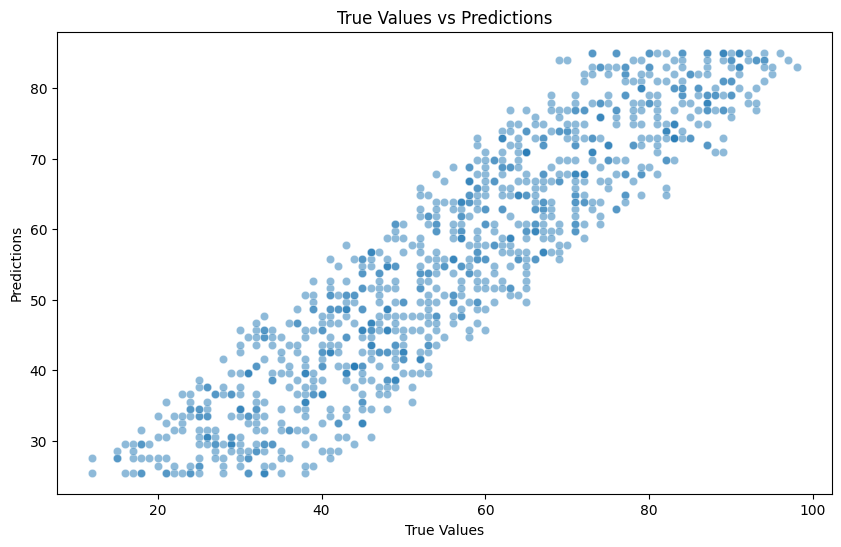

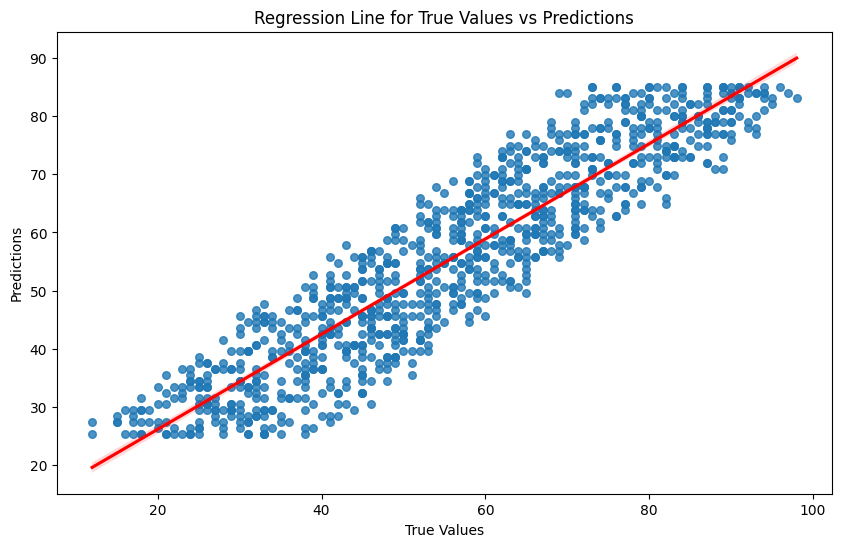

In [104]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
best_feature_model = LinearRegression()
best_feature_model.fit(train[[best_feature]], train[target])

# Dự đoán trên tập kiểm tra
y_pred = best_feature_model.predict(test[[best_feature]])

# Vẽ biểu đồ phân tán của giá trị thực tế và giá trị dự đoán
plot_true_vs_predictions(y_test, y_pred)

# Vẽ đường hồi quy
plot_regression_line(y_test, y_pred)


In [105]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
# Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

#In ra công thức hồi quy
formula = create_regression_formula(best_feature_model.intercept_, best_feature_model.coef_, [best_feature])
print(formula)

Mean Absolute Error: 6.544277293452501
Student Performance = -14.989 + 1.011 * Previous Scores


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = ...$$

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất (2 điểm)

## Xây dựng/Thiết kế mô hình

Model 1 (Hours Studied + Previous Scores) Mean MAE: 1.81603658
Model 2 (Standardized Hours Studied + Previous Scores) Mean MAE: 1.81603658
Model 3 (Combined + Squared Previous Scores) Mean MAE: 2.91137600


C:\Users\Admin\AppData\Local\Temp\ipykernel_14528\3043768685.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


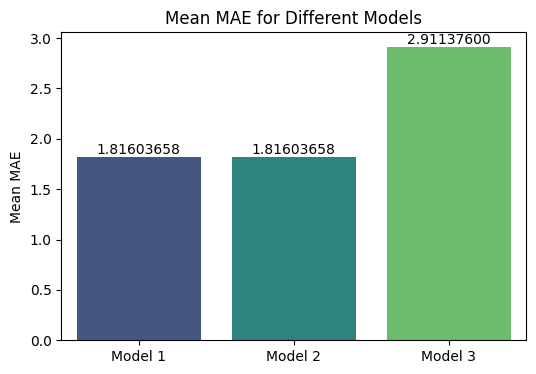

In [106]:
# Trình bày toàn bộ code liên quan đến việc thiết kế mô hình

# Tạo đối tượng KFold với k = 5
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Mô hình 1: Hồi quy tuyến tính với hai đặc trưng "Hours Studied" và "Previous Scores"
X1 = train[['Hours Studied', 'Previous Scores']]
y = train['Performance Index']

model1 = LinearRegression()
# Dự đoán bằng cross_val_predict để tính MAE
y_pred1 = cross_val_predict(model1, X1, y, cv=kf)
mae1 = mean_absolute_error(y, y_pred1)
print(f"Model 1 (Hours Studied + Previous Scores) Mean MAE: {mae1:.8f}")

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X2 = train[['Hours Studied', 'Previous Scores']]
X2_scaled = scaler.fit_transform(X2)

# Mô Hình 2: Hồi quy tuyến tính với các đặc trưng đã chuẩn hóa
model2 = LinearRegression()
# Dự đoán bằng cross_val_predict để tính MAE
y_pred2 = cross_val_predict(model2, X2_scaled, y, cv=kf)
mae2 = mean_absolute_error(y, y_pred2)
print(f"Model 2 (Standardized Hours Studied + Previous Scores) Mean MAE: {mae2:.8f}")

# Tạo đặc trưng mới là tổng và bình phương của một đặc trưng
train['Hours Studied + Previous Scores'] = train['Hours Studied'] + train['Previous Scores']
train['Previous Scores^2'] = train['Previous Scores'] ** 2

X3 = train[['Hours Studied + Previous Scores', 'Previous Scores^2']]

# Mô Hình 3: Hồi quy tuyến tính với các đặc trưng biến đổi
model3 = LinearRegression()
# Dự đoán bằng cross_val_predict để tính MAE
y_pred3 = cross_val_predict(model3, X3, y, cv=kf)
mae3 = mean_absolute_error(y, y_pred3)
print(f"Model 3 (Combined + Squared Previous Scores) Mean MAE: {mae3:.8f}")

# Trực quan hóa kết quả
results = {
    'Model 1': mae1,
    'Model 2': mae2,
    'Model 3': mae3
}

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')

# Thêm giá trị MAE vào từng cột
for p in ax.patches:
    ax.annotate(f'{p.get_height():.8f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.ylabel('Mean MAE')
plt.title('Mean MAE for Different Models')
plt.show()

## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [107]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu

# Chọn mô hình tốt nhất dựa trên MAE
maes = {
    'Model 1': mae1,
    'Model 2': mae2,
    'Model 3': mae3
}

# Tìm mô hình với MAE thấp nhất
best_model_name = min(maes, key=maes.get)
print(f"The best model is: {best_model_name} with Mean MAE: {maes[best_model_name]:.8f}")

The best model is: Model 1


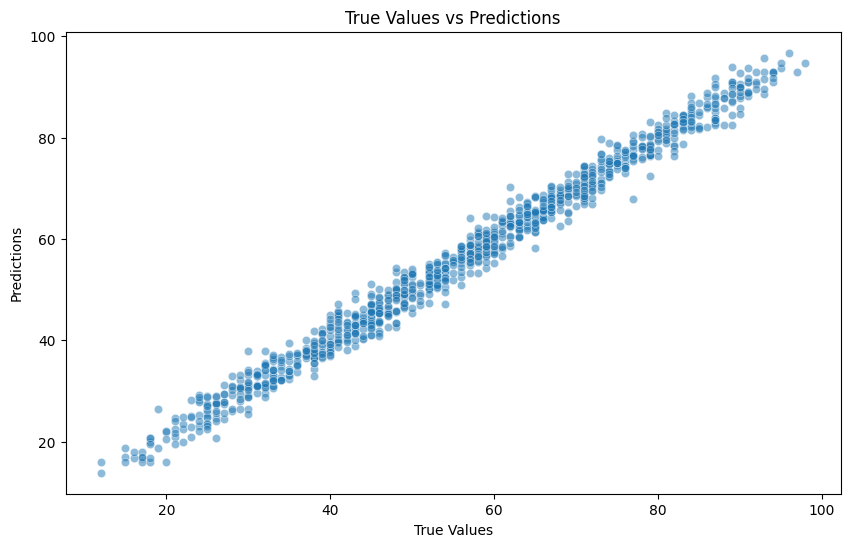

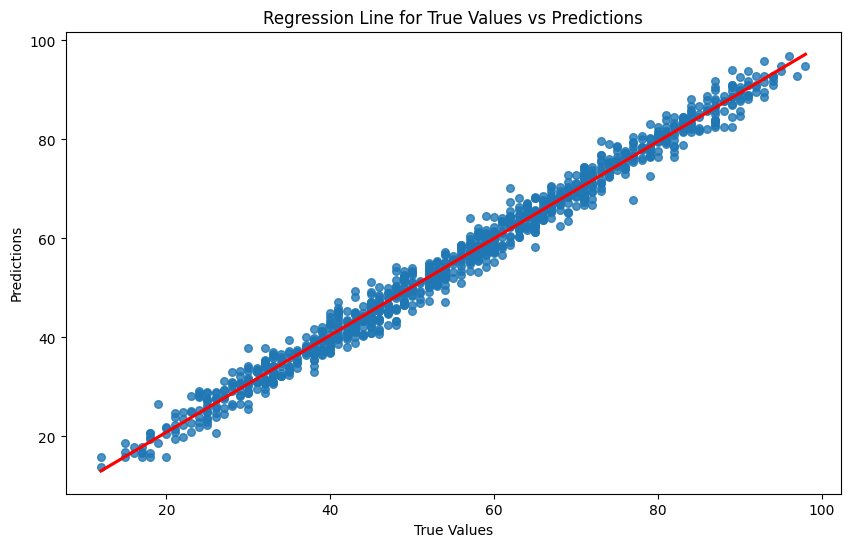

In [108]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
if best_model_name == 'Model 1':
    X_best = train[['Hours Studied', 'Previous Scores']]
elif best_model_name == 'Model 2':
    X_best = scaler.fit_transform(train[['Hours Studied', 'Previous Scores']])
elif best_model_name == 'Model 3':
    X_best = train[['Hours Studied + Previous Scores', 'Previous Scores^2']]

best_model = LinearRegression()
best_model.fit(X_best, train['Performance Index'])


# Dự đoán trên tập kiểm tra
if best_model_name == 'Model 1':
    X_test = test[['Hours Studied', 'Previous Scores']]
elif best_model_name == 'Model 2':
    X_test = scaler.transform(test[['Hours Studied', 'Previous Scores']])
elif best_model_name == 'Model 3':
    test['Hours Studied + Previous Scores'] = test['Hours Studied'] + test['Previous Scores']
    test['Previous Scores^2'] = test['Previous Scores'] ** 2
    X_test = test[['Hours Studied + Previous Scores', 'Previous Scores^2']]

y_pred = best_model.predict(X_test)

# Vẽ biểu đồ phân tán của giá trị thực tế và giá trị dự đoán
plot_true_vs_predictions(y_test, y_pred)

# Vẽ đường hồi quy
plot_regression_line(y_test, y_pred)

In [109]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
# Đánh giá mô hình
printMAE(y_test, y_pred)

# In ra công thức hồi quy
if best_model_name == 'Model 1':
    formula = create_regression_formula(best_model.intercept_, best_model.coef_, ['Hours Studied', 'Previous Scores'])
elif best_model_name == 'Model 2':
    formula = create_regression_formula(best_model.intercept_, best_model.coef_, ['Hours Studied', 'Previous Scores'])
elif best_model_name == 'Model 3':
    formula = create_regression_formula(best_model.intercept_, best_model.coef_, ['Hours Studied + Previous Scores', 'Previous Scores^2'])

print(formula)

Mean Absolute Error: 1.839
Student Performance = -29.747 + 2.856 * Hours Studied + 1.018 * Previous Scores


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = ...$$